In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("predict_insurance_costs").getOrCreate()


data = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("/home/dangkhacloc/Downloads/insurance.csv")


data.cache()
# so dong du lieu
data.count()

1338

In [ ]:
display(data)

data.printSchema()

DataFrame[age: int, sex: string, bmi: double, children: int, smoker: string, region: string, charges: double]

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [ ]:
data.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [ ]:
# Mo ta ve tap du lieu
data.describe().show()
data.createOrReplaceTempView("insurance")
spark.sql("SELECT count(region), region FROM insurance group by region order by region").show(100)

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+

+-------------+---

In [ ]:
data.createOrReplaceTempView("insurance")
# Chuyen doi cac thuoc tinh dang string sang numberic
from pyspark.ml.feature import StringIndexer
# I. With SEX
# Create StringIndexer
sex_indexer = StringIndexer(inputCol = "sex", \
                             outputCol = "sex_index")


# II. With SMOKER
# Create StringIndexer
smoker_indexer = StringIndexer(inputCol = "smoker", \
                             outputCol = "smoker_index")

# III. With REGION
# Create StringIndexer
region_indexer = StringIndexer(inputCol = "region", \
                            outputCol = "region_index")


In [ ]:
# Make a VectorAssembler de gom cac thuoc tinh de du doan vao mot features
from pyspark.ml.feature import VectorAssembler
vec_assembler = VectorAssembler(inputCols = ["age", "sex_index", "bmi", \
                                             "children", "smoker_index",\
                                             "region_index"], 
                                outputCol = "features")

In [ ]:
#Chuyen doi du lieu model thong qua pipeline
from pyspark.ml import Pipeline

# Make a pipeline
flights_sea_pipe  = Pipeline(stages = [sex_indexer, smoker_indexer, \
                                       region_indexer,vec_assembler])

In [ ]:
# create pipe_data from pipeline
pipe_data = flights_sea_pipe.fit(data).transform(data)


In [ ]:
pipe_data.select("features").show()

+--------------------+
|            features|
+--------------------+
|[19.0,1.0,27.9,0....|
|[18.0,0.0,33.77,1...|
|[28.0,0.0,33.0,3....|
|[33.0,0.0,22.705,...|
|[32.0,0.0,28.88,0...|
|[31.0,1.0,25.74,0...|
|[46.0,1.0,33.44,1...|
|[37.0,1.0,27.74,3...|
|[37.0,0.0,29.83,2...|
|[60.0,1.0,25.84,0...|
|[25.0,0.0,26.22,0...|
|[62.0,1.0,26.29,0...|
|[23.0,0.0,34.4,0....|
|[56.0,1.0,39.82,0...|
|[27.0,0.0,42.13,0...|
|[19.0,0.0,24.6,1....|
|[52.0,1.0,30.78,1...|
|[23.0,0.0,23.845,...|
|[56.0,0.0,40.3,0....|
|[30.0,0.0,35.3,0....|
+--------------------+
only showing top 20 rows



In [ ]:
pipe_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)
 |-- sex_index: double (nullable = false)
 |-- smoker_index: double (nullable = false)
 |-- region_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
# Tao tap du lieu train va test
data_train, data_test = pipe_data.randomSplit([0.8, 0.2],1000)
data_train.show(5)
data_test.show(5)

+---+------+------+--------+------+---------+----------+---------+------------+------------+--------------------+
|age|   sex|   bmi|children|smoker|   region|   charges|sex_index|smoker_index|region_index|            features|
+---+------+------+--------+------+---------+----------+---------+------------+------------+--------------------+
| 18|female| 20.79|       0|    no|southeast| 1607.5101|      1.0|         0.0|         0.0|[18.0,1.0,20.79,0...|
| 18|female| 21.66|       0|   yes|northeast|14283.4594|      1.0|         1.0|         3.0|[18.0,1.0,21.66,0...|
| 18|female| 24.09|       1|    no|southeast| 2201.0971|      1.0|         0.0|         0.0|[18.0,1.0,24.09,1...|
| 18|female|26.315|       0|    no|northeast|2198.18985|      1.0|         0.0|         3.0|[18.0,1.0,26.315,...|
| 18|female| 26.73|       0|    no|southeast| 1615.7667|      1.0|         0.0|         0.0|[18.0,1.0,26.73,0...|
+---+------+------+--------+------+---------+----------+---------+------------+---------

In [ ]:
class GDLinearRegression:
    def __init__(self, lr, step):
        '''
        Khởi tạo learning rate và số lượng step update weigh
        '''
        self.lr = lr
        self.step = step
        
    def fit(self, X, y):
        ''' 
        Train the model với đầu vào là tập train data X cùng nhãn Y
        X là ma trận MxN trong đó M là số lượng điểm dữ liệu, mỗi điểm dữ liệu có N chiều.
        Trường hợp dữ liệu 1 chiều thì X là vector cột Mx1
        '''
        # lấy ra số lượng điểm train_size và số chiều dữ liệu n_features
        self.n_features = X.shape[1] if len(X.shape) > 1 else 1 
        train_size = len(X) # số lượng sample
        
        # chuẩn hóa lại định dạng dữ liệu
        X = X.reshape(-1, self.n_features)
        y = y.reshape([-1, 1])
        
        # ta muốn thực hiện dự đoán y = X.T*W + bias, ta đưa bias vào W (W|bias) và 1 cột toàn 1 vào X (X|one),
        # lúc đó việc tính toán thuận tiện hơn y = (X|one).T*(W|bias) => đây là trick để tính toán cho nhanh
        one = np.ones([train_size, 1])
        X = np.concatenate([X, one], 1)
        
        # tạo weight chính là parameters ta sẽ optimize trong quá trình train
        self.weight = np.zeros([self.n_features + 1, 1])
        print('x shape: ', X.shape, '- y shape: ', y.shape, '- weight shape: ', self.weight.shape, 'train_size: ', train_size)
        
        # mảng lưu lại toàn bộ giá trị loss trong quá trình train
        self.train_loss = []
        
        # train
        for i in range(self.step):
            
            loss = np.sum((y - np.dot(X, self.weight)) ** 2)
            delta = np.dot(X.T, ( np.dot(X, self.weight) - y))
            
            # update weight
            self.weight = self.weight - (self.lr/train_size) * delta
            
            # tính trung bình loss
            loss = loss/train_size
            self.train_loss.append(loss.item())
    
    def predict(self, X):
        '''
        Thực hiện dự đoán
        '''
        # chuẩn hóa format dữ liệu như ta đã làm trong lúc train
        X = X.reshape(-1, self.n_features)
        
        # thêm cột one như ta đã làm trong lúc train
        one = np.ones([len(X), 1])
        X = np.concatenate([X, one], 1)
        
        # thực hiện dự đoán, đơn giản là nhân ma trận
        y_hat = np.dot(X, self.weight)
        
        return y_hat
    
    def print_weight(self):
        '''
        In weigt đã học được
        '''
        print(self.weight)
        
    def get_train_loss(self):
        '''
        Trả về train loss đã lưu trong quá trình train
        '''
        return self.train_loss

In [ ]:
X_train  = data_train.select("age", "sex_index", "bmi","children", "smoker_index","region_index")

y_train  = data_train.select("charges")

X_test  = data_test.select("age", "sex_index", "bmi","children", "smoker_index","region_index")

y_test  = data_test.select("charges")


In [ ]:
model = GDLinearRegression(0.0001, 100)
import numpy as np
import time
start=time.time()
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
end=time.time()
difference=end-start
print("Time taken in seconds:",difference)

x shape:  (1070, 7) - y shape:  (1070, 1) - weight shape:  (7, 1) train_size:  1070
Time taken in seconds: 0.768998384475708


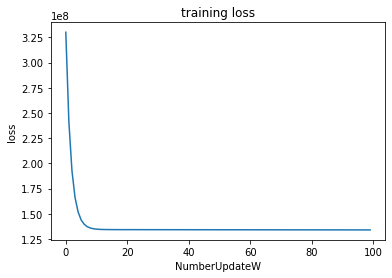

last loss:  133988541.29758854
[[ 8114.38494911  2196.4732    ]
 [ 8642.22480704  2200.83085   ]
 [ 8802.17627914  7323.734819  ]
 [ 9266.03554823  2205.9808    ]
 [10093.85377026  1629.8335    ]
 [10334.62282826 14133.03775   ]
 [ 7781.57290543  1704.70015   ]
 [ 7830.47452077  1711.0268    ]
 [ 8181.45158568  1708.0014    ]
 [ 9047.94045684  3481.868     ]
 [ 9277.15951805 33732.6867    ]
 [ 9689.48448906  1137.4697    ]
 [ 9830.70977186  1727.54      ]
 [10819.24699199  1146.7966    ]
 [ 7800.65861848 13844.506     ]
 [ 8911.90042464 17081.08      ]
 [ 9124.42716407  1744.465     ]
 [ 9476.20818229  2719.27975   ]
 [ 7527.99849081  1242.26      ]
 [ 7548.29615941  1625.43375   ]
 [ 7916.18454524  1628.4709    ]
 [ 8412.03410875  1632.56445   ]
 [ 9241.81075965 32548.3405    ]
 [ 9851.50408551  1261.442     ]
 [ 8892.24804879 17085.2676    ]
 [ 9474.2725499   2459.7201    ]
 [ 9618.50869118  1877.9294    ]
 [ 9929.80659259  1880.487     ]
 [ 9893.96205454  1980.07      ]
 [ 9936.4465

In [ ]:
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))

print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()

In [ ]:

#plt.plot(X_test.collect(), y_hat, color="blue")
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(np.array(y_test.collect()), y_hat)
print(mse)

116128043.38352466


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(np.array(y_test.collect()), y_hat)
print(r2)

0.08990387404362643


In [ ]:
from sklearn.metrics import mean_absolute_error
mae= mean_absolute_error(np.array(y_test.collect()), y_hat)
print(mae)



8763.367188868586


x shape:  (1070, 2) - y shape:  (1070, 1) - weight shape:  (2, 1) train_size:  1070


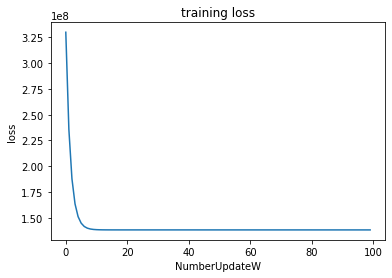

last loss:  138144026.7237509
[[ 6049.48122659  2196.4732    ]
 [ 6049.48122659  2200.83085   ]
 [ 6049.48122659  7323.734819  ]
 [ 6049.48122659  2205.9808    ]
 [ 6049.48122659  1629.8335    ]
 [ 6049.48122659 14133.03775   ]
 [ 6049.48122659  1704.70015   ]
 [ 6049.48122659  1711.0268    ]
 [ 6049.48122659  1708.0014    ]
 [ 6049.48122659  3481.868     ]
 [ 6049.48122659 33732.6867    ]
 [ 6049.48122659  1137.4697    ]
 [ 6049.48122659  1727.54      ]
 [ 6049.48122659  1146.7966    ]
 [ 6383.34054907 13844.506     ]
 [ 6383.34054907 17081.08      ]
 [ 6383.34054907  1744.465     ]
 [ 6383.34054907  2719.27975   ]
 [ 6383.34054907  1242.26      ]
 [ 6383.34054907  1625.43375   ]
 [ 6383.34054907  1628.4709    ]
 [ 6383.34054907  1632.56445   ]
 [ 6383.34054907 32548.3405    ]
 [ 6383.34054907  1261.442     ]
 [ 6717.19987156 17085.2676    ]
 [ 6717.19987156  2459.7201    ]
 [ 6717.19987156  1877.9294    ]
 [ 6717.19987156  1880.487     ]
 [ 6717.19987156  1980.07      ]
 [ 6717.19987

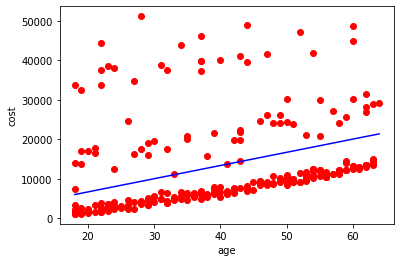

In [ ]:
#Age and Insurance Cost
X_train  = data_train.select("age")
X_test  = data_test.select("age")
model = GDLinearRegression(0.001, 100)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('age')
plt.ylabel('cost')
plt.show()

x shape:  (1070, 2) - y shape:  (1070, 1) - weight shape:  (2, 1) train_size:  1070


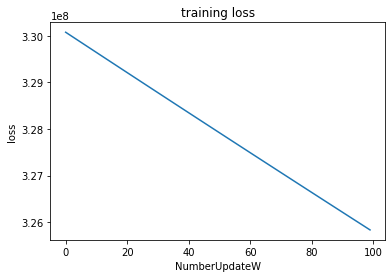

last loss:  325830870.1381214
[[  194.47709246  2196.4732    ]
 [  194.47709246  2200.83085   ]
 [  194.47709246  7323.734819  ]
 [  194.47709246  2205.9808    ]
 [  194.47709246  1629.8335    ]
 [  194.47709246 14133.03775   ]
 [  132.92180012  1704.70015   ]
 [  132.92180012  1711.0268    ]
 [  132.92180012  1708.0014    ]
 [  132.92180012  3481.868     ]
 [  132.92180012 33732.6867    ]
 [  132.92180012  1137.4697    ]
 [  132.92180012  1727.54      ]
 [  132.92180012  1146.7966    ]
 [  194.47709246 13844.506     ]
 [  194.47709246 17081.08      ]
 [  194.47709246  1744.465     ]
 [  194.47709246  2719.27975   ]
 [  132.92180012  1242.26      ]
 [  132.92180012  1625.43375   ]
 [  132.92180012  1628.4709    ]
 [  132.92180012  1632.56445   ]
 [  132.92180012 32548.3405    ]
 [  132.92180012  1261.442     ]
 [  194.47709246 17085.2676    ]
 [  194.47709246  2459.7201    ]
 [  194.47709246  1877.9294    ]
 [  194.47709246  1880.487     ]
 [  132.92180012  1980.07      ]
 [  132.92180

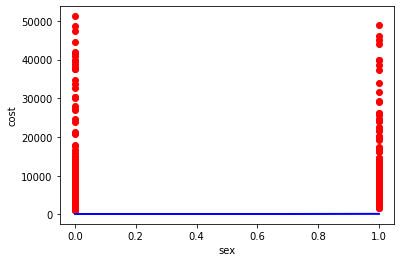

In [ ]:
#sex and Insurance Cost
X_train  = data_train.select("sex_index")
X_test  = data_test.select("sex_index")
model = GDLinearRegression(0.0001, 100)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('sex')
plt.ylabel('cost')
plt.show()

x shape:  (1070, 2) - y shape:  (1070, 1) - weight shape:  (2, 1) train_size:  1070


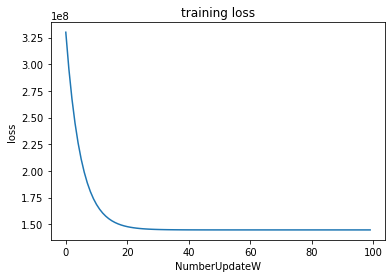

last loss:  144606921.65462184
[[10946.19817766  2196.4732    ]
 [12312.74605245  2200.83085   ]
 [12726.85146905  7323.734819  ]
 [13927.75717719  2205.9808    ]
 [16076.74633914  1629.8335    ]
 [16700.08396623 14133.03775   ]
 [10076.5768028   1704.70015   ]
 [10179.01340585  1711.0268    ]
 [11111.8403443   1708.0014    ]
 [13265.18851063  3481.868     ]
 [13844.93609387 33732.6867    ]
 [15021.8672779   1137.4697    ]
 [15357.51061557  1727.54      ]
 [17946.75922042  1146.7966    ]
 [ 9472.85469544 13844.506     ]
 [12349.79758972 17081.08      ]
 [13003.64824751  1744.465     ]
 [13886.34663553  2719.27975   ]
 [ 8862.5940815   1242.26      ]
 [ 8917.08163631  1625.43375   ]
 [ 9869.5240945   1628.4709    ]
 [11153.25088596  1632.56445   ]
 [13199.80344485 32548.3405    ]
 [14878.02013319  1261.442     ]
 [11713.38294947 17085.2676    ]
 [13348.00959395  2459.7201    ]
 [13727.24297547  1877.9294    ]
 [14529.29978236  1880.487     ]
 [14398.5296508   1980.07      ]
 [14542.3767

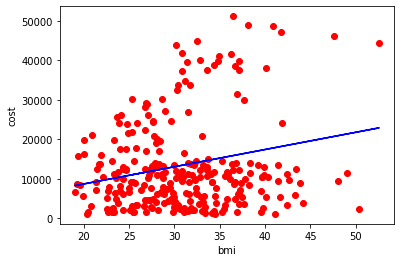

In [ ]:
#bmi and Insurance Cost
X_train  = data_train.select("bmi")
X_test  = data_test.select("bmi")
model = GDLinearRegression(0.0001, 100)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('bmi')
plt.ylabel('cost')
plt.show()

x shape:  (1070, 2) - y shape:  (1070, 1) - weight shape:  (2, 1) train_size:  1070


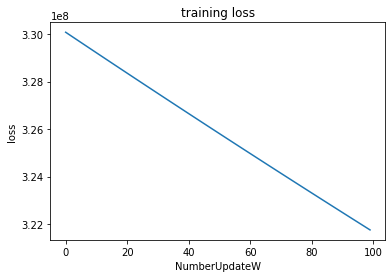

last loss:  321751609.6524197
[[  132.20777075  2196.4732    ]
 [  132.20777075  2200.83085   ]
 [  132.20777075  7323.734819  ]
 [  132.20777075  2205.9808    ]
 [  132.20777075  1629.8335    ]
 [  132.20777075 14133.03775   ]
 [  132.20777075  1704.70015   ]
 [  288.96387898  1711.0268    ]
 [  132.20777075  1708.0014    ]
 [  602.47609543  3481.868     ]
 [  132.20777075 33732.6867    ]
 [  132.20777075  1137.4697    ]
 [  288.96387898  1727.54      ]
 [  132.20777075  1146.7966    ]
 [  132.20777075 13844.506     ]
 [  132.20777075 17081.08      ]
 [  132.20777075  1744.465     ]
 [  288.96387898  2719.27975   ]
 [  132.20777075  1242.26      ]
 [  132.20777075  1625.43375   ]
 [  132.20777075  1628.4709    ]
 [  132.20777075  1632.56445   ]
 [  132.20777075 32548.3405    ]
 [  132.20777075  1261.442     ]
 [  288.96387898 17085.2676    ]
 [  132.20777075  2459.7201    ]
 [  132.20777075  1877.9294    ]
 [  132.20777075  1880.487     ]
 [  288.96387898  1980.07      ]
 [  132.20777

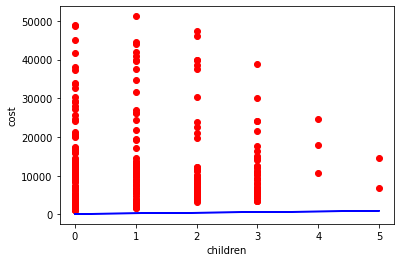

In [ ]:
#children and Insurance Cost
X_train  = data_train.select("children")
X_test  = data_test.select("children")
model = GDLinearRegression(0.0001, 100)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('children')
plt.ylabel('cost')
plt.show()

x shape:  (1070, 2) - y shape:  (1070, 1) - weight shape:  (2, 1) train_size:  1070


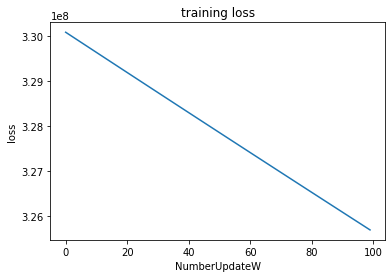

last loss:  325693831.4307417
[[  133.00507853  2196.4732    ]
 [  133.00507853  2200.83085   ]
 [  133.00507853  7323.734819  ]
 [  133.00507853  2205.9808    ]
 [  133.00507853  1629.8335    ]
 [  133.00507853 14133.03775   ]
 [  133.00507853  1704.70015   ]
 [  133.00507853  1711.0268    ]
 [  133.00507853  1708.0014    ]
 [  133.00507853  3481.868     ]
 [  199.78378722 33732.6867    ]
 [  133.00507853  1137.4697    ]
 [  133.00507853  1727.54      ]
 [  133.00507853  1146.7966    ]
 [  199.78378722 13844.506     ]
 [  199.78378722 17081.08      ]
 [  133.00507853  1744.465     ]
 [  133.00507853  2719.27975   ]
 [  133.00507853  1242.26      ]
 [  133.00507853  1625.43375   ]
 [  133.00507853  1628.4709    ]
 [  133.00507853  1632.56445   ]
 [  199.78378722 32548.3405    ]
 [  133.00507853  1261.442     ]
 [  199.78378722 17085.2676    ]
 [  133.00507853  2459.7201    ]
 [  133.00507853  1877.9294    ]
 [  133.00507853  1880.487     ]
 [  133.00507853  1980.07      ]
 [  133.00507

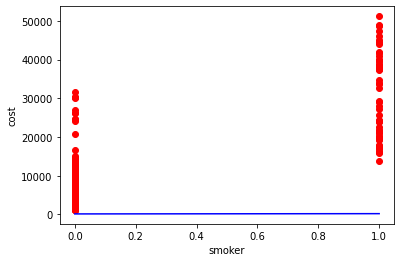

In [ ]:
#smoking and Insurance Cost
X_train  = data_train.select("smoker_index")
X_test  = data_test.select("smoker_index")
model = GDLinearRegression(0.0001, 100)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('smoker')
plt.ylabel('cost')
plt.show()

x shape:  (1070, 2) - y shape:  (1070, 1) - weight shape:  (2, 1) train_size:  1070


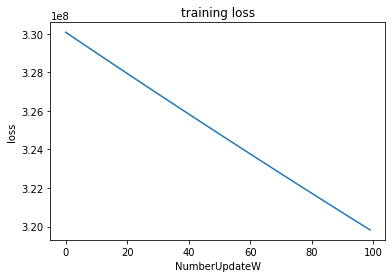

last loss:  319825796.13535833
[[  688.28760757  2196.4732    ]
 [  688.28760757  2200.83085   ]
 [  688.28760757  7323.734819  ]
 [  688.28760757  2205.9808    ]
 [  131.73400315  1629.8335    ]
 [  131.73400315 14133.03775   ]
 [  688.28760757  1704.70015   ]
 [  131.73400315  1711.0268    ]
 [  688.28760757  1708.0014    ]
 [  688.28760757  3481.868     ]
 [  688.28760757 33732.6867    ]
 [  131.73400315  1137.4697    ]
 [  131.73400315  1727.54      ]
 [  131.73400315  1146.7966    ]
 [  502.76973943 13844.506     ]
 [  502.76973943 17081.08      ]
 [  502.76973943  1744.465     ]
 [  317.25187129  2719.27975   ]
 [  502.76973943  1242.26      ]
 [  317.25187129  1625.43375   ]
 [  317.25187129  1628.4709    ]
 [  317.25187129  1632.56445   ]
 [  131.73400315 32548.3405    ]
 [  502.76973943  1261.442     ]
 [  131.73400315 17085.2676    ]
 [  688.28760757  2459.7201    ]
 [  131.73400315  1877.9294    ]
 [  502.76973943  1880.487     ]
 [  502.76973943  1980.07      ]
 [  131.7340

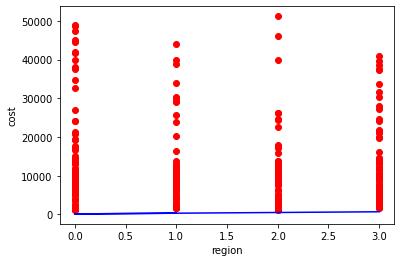

In [ ]:
#region and Insurance Cost
X_train  = data_train.select("region_index")
X_test  = data_test.select("region_index")
model = GDLinearRegression(0.0001, 100)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('region')
plt.ylabel('cost')
plt.show()